In [1]:
library("lme4")
library("ggplot2")
library("dplyr")
library(MASS)
library("BayesFactor")
library("car")
library("scales")
library("lmerTest")
#library("MuMIn")
library("plyr")
library("knitr")
library("MASS")
library("corrplot")
library("RColorBrewer")
library("rstatix")
library("ggpubr")
#library("rgr")
library("lattice")
library("correlation")
library("cowplot")

Loading required package: Matrix


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: coda

************
Welcome to BayesFactor 0.9.12-4.4. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode



Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functi

In [2]:
##Source for "SummarySE": http://www.cookbook-r.com/Manipulating_data/Summarizing_data/
##
##
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

In [3]:
DataPath <-'./R_Data_ALL.txt'
data <- read.delim(DataPath, sep="\t", header=T, stringsAsFactors=F)
nb_rows<-nrow(data)
nb_rows
head(data,10)

[1] 2115

,Type,Speed,Agent,subject,GameNb,Deflations,Misses,Resets,ShotReg,Entropy,LogCV,ShotPer,RightReg,RightPer,Score
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Human,FFF,Human_FFF,A11LNK1U3DT08V,1,23,45,17,0.5308518,3.117663,-1.045539,512,0.3869265,528,526
2,Human,FFF,Human_FFF,A11LNK1U3DT08V,2,15,39,9,0.4488193,3.063328,-1.257139,496,0.3037540,496,1626
3,Human,FFF,Human_FFF,A11LNK1U3DT08V,3,19,50,10,0.3585762,3.053468,-1.233135,480,0.2317211,496,1604
4,Human,FFF,Human_FFF,A11LNK1U3DT08V,4,11,33,11,0.4825653,2.692394,-1.325335,512,0.3582805,512,1640
5,Human,FFF,Human_FFF,A11LNK1U3DT08V,5,19,49,12,0.3362358,3.552236,-1.092696,432,0.1994396,432,1408
6,Human,FFF,Human_FFF,A11LNK1U3DT08V,6,12,31,4,0.6172684,2.654637,-1.510542,496,0.4029821,496,1640
7,Human,FFF,Human_FFF,A11LNK1U3DT08V,7,12,30,2,0.5474491,2.438955,-1.556296,496,0.3957245,496,1840
8,Human,FFF,Human_FFF,A11LNK1U3DT08V,8,18,30,7,0.4991873,2.795948,-1.378016,480,0.2724625,496,1844
9,Human,FFF,Human_FFF,A11LNK1U3DT08V,9,18,25,4,0.5047437,2.747487,-1.326809,496,0.3023007,496,1656


In [4]:
table(data$Agent, data$GameNb)

           
              1   2   3   4   5   6   7   8   9  10  11  12  13  14  15
  Human_FFF  41  41  41  41  41  41  41  41  41  41  41  41  41  41  41
  MS17_FFF  100 100 100 100 100 100 100 100 100 100 100 100 100 100 100

In [5]:
fast_data <- data

ar <- 0.4
just_ratio <- 0.5
sz_line <- 0.6

# Compute RMSE for FFF data

In [6]:
#RMSE function definition
RMSE = function(mod, obs){
  sqrt(mean((mod - obs)^2))
}

#Filtered data set
head(fast_data,10)

,Type,Speed,Agent,subject,GameNb,Deflations,Misses,Resets,ShotReg,Entropy,LogCV,ShotPer,RightReg,RightPer,Score
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Human,FFF,Human_FFF,A11LNK1U3DT08V,1,23,45,17,0.5308518,3.117663,-1.045539,512,0.3869265,528,526
2,Human,FFF,Human_FFF,A11LNK1U3DT08V,2,15,39,9,0.4488193,3.063328,-1.257139,496,0.3037540,496,1626
3,Human,FFF,Human_FFF,A11LNK1U3DT08V,3,19,50,10,0.3585762,3.053468,-1.233135,480,0.2317211,496,1604
4,Human,FFF,Human_FFF,A11LNK1U3DT08V,4,11,33,11,0.4825653,2.692394,-1.325335,512,0.3582805,512,1640
5,Human,FFF,Human_FFF,A11LNK1U3DT08V,5,19,49,12,0.3362358,3.552236,-1.092696,432,0.1994396,432,1408
6,Human,FFF,Human_FFF,A11LNK1U3DT08V,6,12,31,4,0.6172684,2.654637,-1.510542,496,0.4029821,496,1640
7,Human,FFF,Human_FFF,A11LNK1U3DT08V,7,12,30,2,0.5474491,2.438955,-1.556296,496,0.3957245,496,1840
8,Human,FFF,Human_FFF,A11LNK1U3DT08V,8,18,30,7,0.4991873,2.795948,-1.378016,480,0.2724625,496,1844
9,Human,FFF,Human_FFF,A11LNK1U3DT08V,9,18,25,4,0.5047437,2.747487,-1.326809,496,0.3023007,496,1656


In [7]:
#1) Performance results
muTab<-aggregate(fast_data$Score, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)
colnames(muTab)<-c("Agent","GameNb","Score")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Human_FFF" & muTab$GameNb==i),]$Score
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="MS17_FFF" & muTab$GameNb==i),]$Score
}

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
r_perf <- cor(H_vec,M_vec,method = "pearson")
rmse_perf <- RMSE(M_vec,H_vec)
r_perf
rmse_perf

[1] 0.9655402

[1] 532.1413

In [8]:
#2) Entropy results
fast_data <- data
fast_data <- fast_data %>% filter(!Entropy=='NaN')
muTab<-aggregate(fast_data$Entropy, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)
colnames(muTab)<-c("Agent","GameNb","Entropy")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Human_FFF" & muTab$GameNb==i),]$Entropy
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="MS17_FFF" & muTab$GameNb==i),]$Entropy
}

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
r_ent <- cor(H_vec,M_vec,method = "pearson")
rmse_ent <- RMSE(M_vec,H_vec)
r_ent
rmse_ent

[1] 0.3251299

[1] 0.3039153

In [9]:
#3) Log CV ISI
fast_data <- data 
fast_data <- fast_data %>% filter(!LogCV=='NaN')
muTab<-aggregate(fast_data$LogCV, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","LogCV")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Human_FFF" & muTab$GameNb==i),]$LogCV
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="MS17_FFF" & muTab$GameNb==i),]$LogCV
}

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
r_lcv <- cor(H_vec,M_vec,method = "pearson")
rmse_lcv <- RMSE(M_vec,H_vec)
r_lcv
rmse_lcv

[1] -0.8567695

[1] 0.3646781

In [10]:
#4) Resets
#fast_data <- fast_data %>% filter(!LogCV=='NaN')
fast_data <- data 
muTab<-aggregate(fast_data$Resets, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","Resets")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Human_FFF" & muTab$GameNb==i),]$Resets
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="MS17_FFF" & muTab$GameNb==i),]$Resets
}

#correlations & RMSE per condition
r_res <- cor(H_vec,M_vec,method = "pearson")
rmse_res <- RMSE(M_vec,H_vec)
r_res
rmse_res

[1] -0.303105

[1] 9.07173

In [11]:
#5) Deflations
#fast_data <- fast_data %>% filter(!LogCV=='NaN')
fast_data <- data 
muTab<-aggregate(fast_data$Deflations, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","Deflations")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Human_FFF" & muTab$GameNb==i),]$Deflations
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="MS17_FFF" & muTab$GameNb==i),]$Deflations
}

#correlations & RMSE per condition
r_def <- cor(H_vec,M_vec,method = "pearson")
rmse_def <- RMSE(M_vec,H_vec)
r_def
rmse_def

[1] 0.9309152

[1] 28.2516

In [12]:
#6) Misses
#fast_data <- fast_data %>% filter(!LogCV=='NaN')
fast_data <- data 
muTab<-aggregate(fast_data$Misses, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","Misses")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Human_FFF" & muTab$GameNb==i),]$Misses
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="MS17_FFF" & muTab$GameNb==i),]$Misses
}

#correlations & RMSE per condition
r_mis <- cor(H_vec,M_vec,method = "pearson")
rmse_mis <- RMSE(M_vec,H_vec)
r_mis
rmse_mis

[1] 0.8428299

[1] 37.73038

In [13]:
#7) Shot periodicity
fast_data <- data
fast_data <- fast_data %>% filter(!ShotPer=='NaN')
muTab<-aggregate(fast_data$ShotPer, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","ShotPer")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Human_FFF" & muTab$GameNb==i),]$ShotPer
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="MS17_FFF" & muTab$GameNb==i),]$ShotPer
}

#correlations & RMSE per condition
r_per <- cor(H_vec,M_vec,method = "pearson")
rmse_per <- RMSE(M_vec,H_vec)
r_per
rmse_per

[1] 0.6170209

[1] 51.14604

In [14]:
#8) Shot regularity
fast_data <- data 
fast_data <- fast_data %>% filter(!ShotReg=='NaN')
muTab<-aggregate(fast_data$ShotReg, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","ShotReg")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Human_FFF" & muTab$GameNb==i),]$ShotReg
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="MS17_FFF" & muTab$GameNb==i),]$ShotReg
}

#correlations & RMSE per condition
r_reg <- cor(H_vec,M_vec,method = "pearson")
rmse_reg <- RMSE(M_vec,H_vec)
r_reg
rmse_reg

[1] -0.6716316

[1] 0.2275115

In [15]:
#9) Right regularity
fast_data <- data
fast_data <- fast_data %>% filter(!RightReg=='NaN')
muTab<-aggregate(fast_data$RightReg, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","RightReg")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Human_FFF" & muTab$GameNb==i),]$RightReg
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="MS17_FFF" & muTab$GameNb==i),]$RightReg
}

#correlations & RMSE per condition
r_Rreg <- cor(H_vec,M_vec,method = "pearson")
rmse_Rreg <- RMSE(M_vec,H_vec)
r_Rreg
rmse_Rreg

[1] -0.7165343

[1] 0.1134952

# Compare Humans and ACT-R models

In [16]:
fast_data <- data 
ar <- 0.4
just_ratio <- 0.5
sz_line <- 0.6

Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


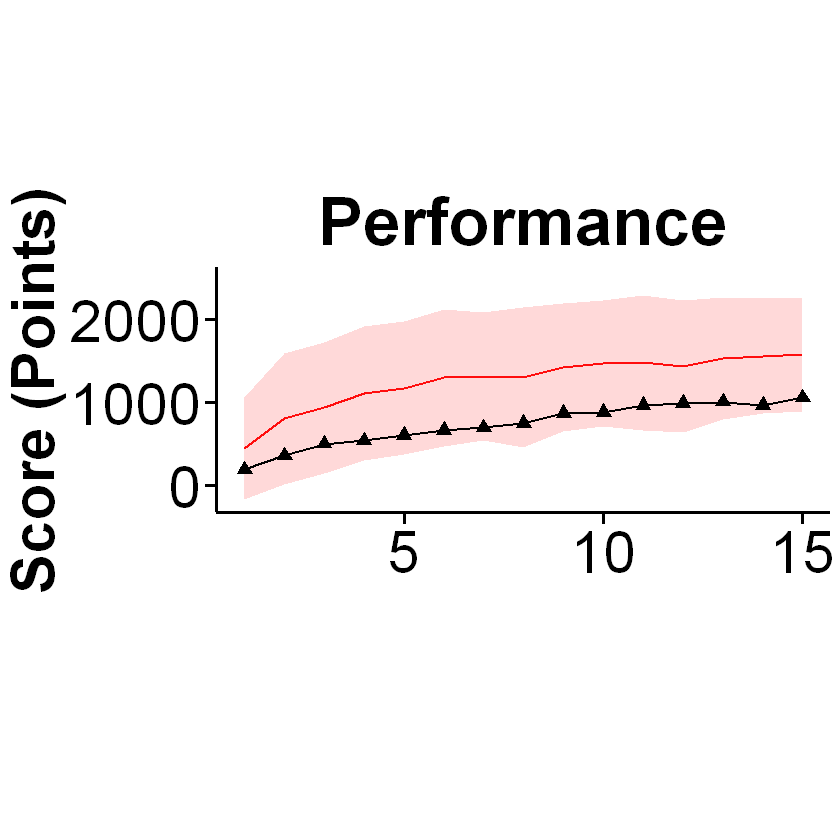

In [17]:
#Performance
Shaded <- fast_data %>% filter(Agent=="Human_FFF")
datac_fast <- summarySE(Shaded, measurevar="Score", groupvars=c("GameNb","Agent"))
ACTR <- fast_data %>% filter(Agent=='MS17_FFF')
datac_model <- summarySE(ACTR, measurevar="Score", groupvars=c("GameNb","Agent"))

p2 <- ggplot(datac_fast) +  geom_line(aes(x=GameNb, y=Score,colour=Agent),linewidth=sz_line) + geom_ribbon(aes(x=GameNb, ymin=Score-sd, ymax=Score+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Performance") +
      theme(plot.title = element_text(size=40,hjust=just_ratio,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', linewidth = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36 ,face ="bold"),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("brown1"), .2), name = "Variation (SD)") + 
     scale_color_manual(values = c("black","red"), name = "Agent means",labels=c("Human","Baseline model")) + 
     scale_x_continuous(name="", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Score (Points)", limits=c(-200, 2500))
p2 <- p2+ geom_line(data = datac_model, aes(x=GameNb, y=Score,color="Baseline model"),size=sz_line) +
      geom_point(data = datac_model, color = "black", aes(x=GameNb, y=Score), shape=17,size = 3.2)
p2

pathFig <- './Figures_B/Performance.png'
ggsave(pathFig,p2,width=15,height=5)

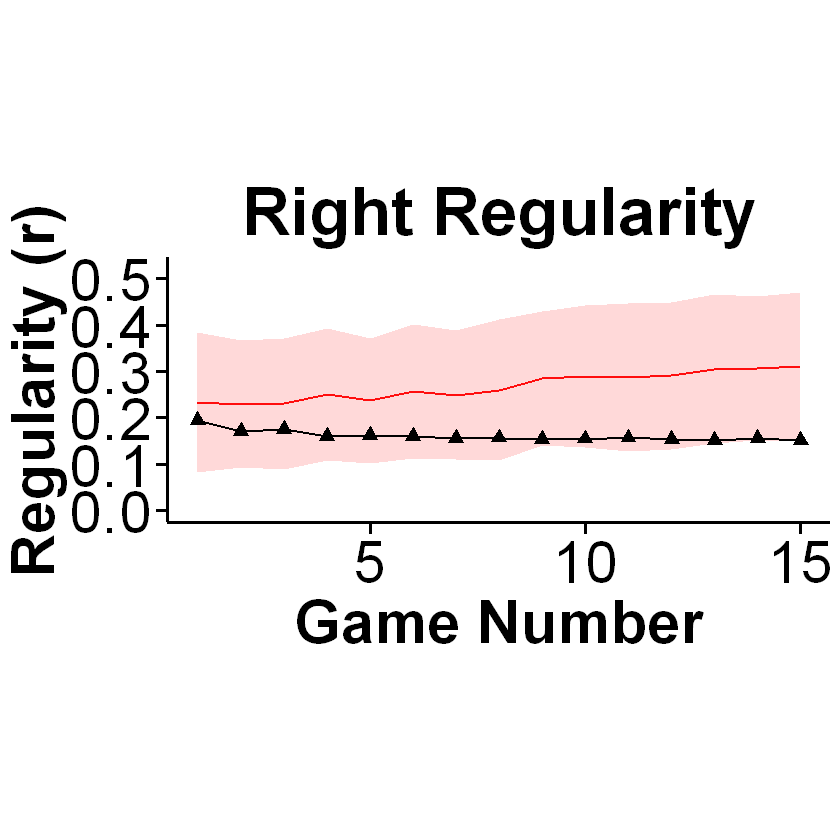

In [20]:
#Right regularity
Shaded <- fast_data %>% filter(Agent=="Human_FFF") %>% filter(!RightReg=='NaN')
datac_fast <- summarySE(Shaded, measurevar="RightReg", groupvars=c("GameNb","Agent"))
ACTR <- fast_data %>% filter(Agent=='MS17_FFF') %>% filter(!RightReg=='NaN')
datac_model <- summarySE(ACTR, measurevar="RightReg", groupvars=c("GameNb","Agent"))

p1 <- ggplot(datac_fast) +  geom_line(aes(x=GameNb, y=RightReg,colour=Agent),size=sz_line) + geom_ribbon(aes(x=GameNb, ymin=RightReg-sd, ymax=RightReg+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Right Regularity") +
      theme(plot.title = element_text(size=40,hjust=just_ratio,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', linewidth = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36 ,face ="bold"),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("brown1"), .2), name = "Variation (SD)") + 
     scale_color_manual(values = c("black","red"), name = "Agent means",labels=c("Human","Baseline model")) + 
     scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Regularity (r)", limits=c(0, 0.52))
p1 <- p1+ geom_line(data = datac_model, aes(x=GameNb, y=RightReg,color="Baseline model"),size=sz_line) +
      geom_point(data = datac_model, color = "black", aes(x=GameNb, y=RightReg), shape=17,size = 3.2)
p1

pathFig <- './Figures_B/Right_Regularity.png'
ggsave(pathFig,p1,width=15,height=5)

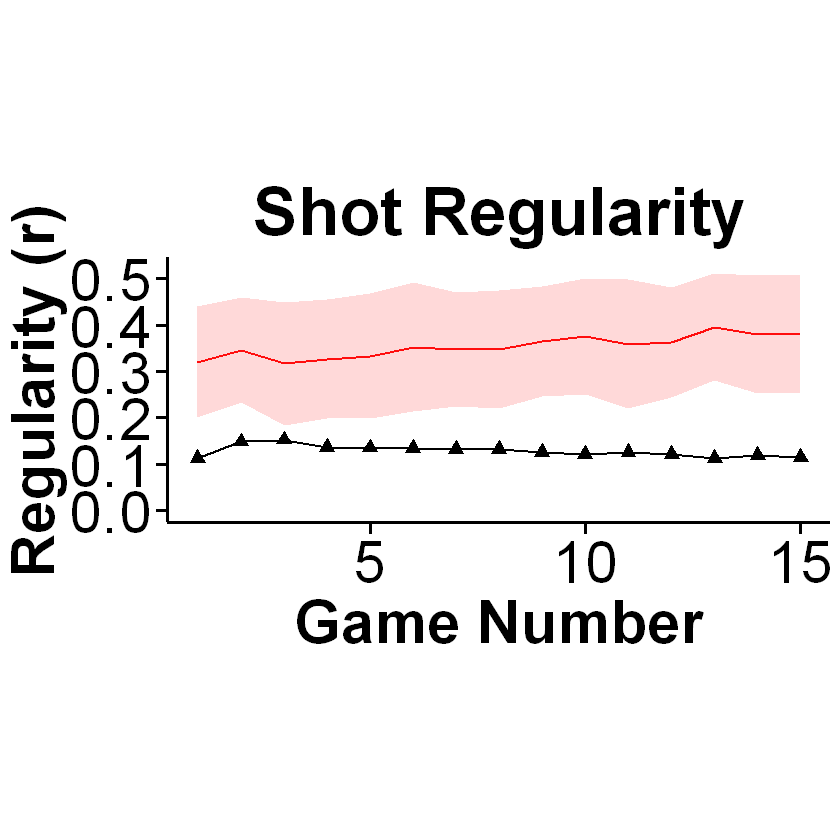

In [21]:
#Shot regularity
Shaded <- fast_data %>% filter(Agent=="Human_FFF") %>% filter(!RightReg=='NaN')
datac_fast <- summarySE(Shaded, measurevar="ShotReg", groupvars=c("GameNb","Agent"))
ACTR <- fast_data %>% filter(Agent=='MS17_FFF') %>% filter(!RightReg=='NaN')
datac_model <- summarySE(ACTR, measurevar="ShotReg", groupvars=c("GameNb","Agent"))

p3 <- ggplot(datac_fast) +  geom_line(aes(x=GameNb, y=ShotReg,colour=Agent),size=sz_line) + geom_ribbon(aes(x=GameNb, ymin=ShotReg-sd, ymax=ShotReg+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Shot Regularity") +
      theme(plot.title = element_text(size=40,hjust=just_ratio,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', linewidth = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36 ,face ="bold"),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("brown1"), .2), name = "Variation (SD)") + 
     scale_color_manual(values = c("black","red"), name = "Agent means",labels=c("Human","Baseline model")) + 
     scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Regularity (r)", limits=c(0, 0.52))
p3 <- p3+ geom_line(data = datac_model, aes(x=GameNb, y=ShotReg,color="Baseline model"),size=sz_line) +
      geom_point(data = datac_model, color = "black", aes(x=GameNb, y=ShotReg), shape=17,size = 3.2)
p3

pathFig <- './Figures_B/Shot_Regularity.png'
ggsave(pathFig,p3,width=15,height=5)

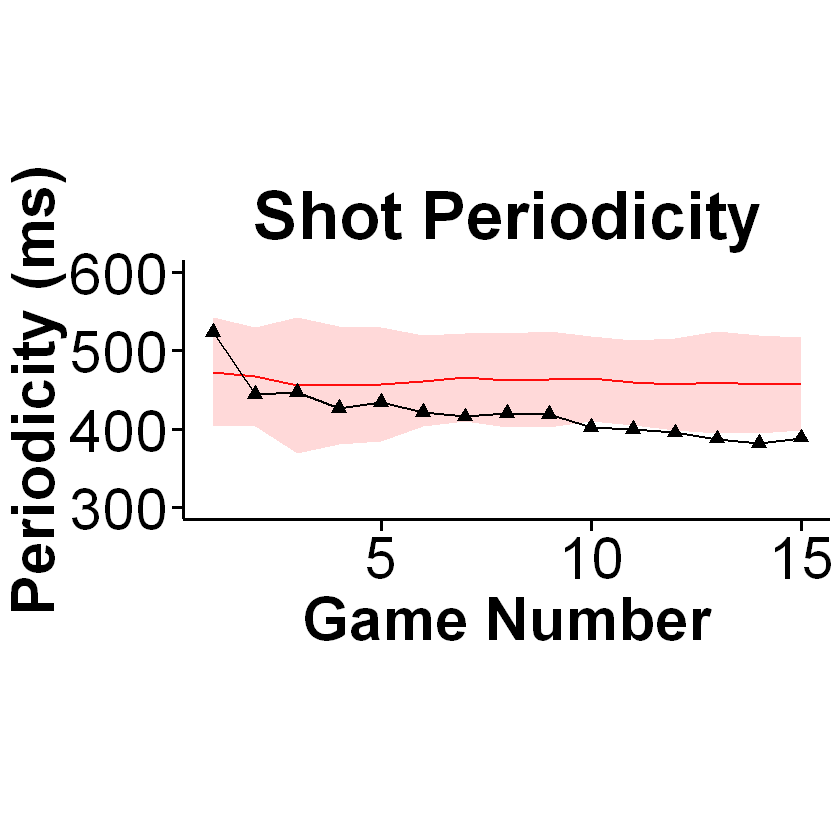

In [19]:
#Shot periodicity
Shaded <- fast_data %>% filter(Agent=="Human_FFF") %>% filter(!ShotPer=='NaN')
datac_fast <- summarySE(Shaded, measurevar="ShotPer", groupvars=c("GameNb","Agent"))
ACTR <- fast_data %>% filter(Agent=='MS17_FFF') %>% filter(!ShotPer=='NaN')
datac_model <- summarySE(ACTR, measurevar="ShotPer", groupvars=c("GameNb","Agent"))

p4 <- ggplot(datac_fast) +  geom_line(aes(x=GameNb, y=ShotPer,colour=Agent),size=sz_line) + geom_ribbon(aes(x=GameNb, ymin=ShotPer-sd, ymax=ShotPer+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Shot Periodicity") +
      theme(plot.title = element_text(size=40,hjust=just_ratio,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', linewidth = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36 ,face ="bold"),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("brown1"), .2), name = "Variation (SD)") + 
     scale_color_manual(values = c("black","red"), name = "Agent means",labels=c("Human","Baseline model")) + 
     scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Periodicity (ms)", limits=c(300,600))
p4 <- p4+ geom_line(data = datac_model, aes(x=GameNb, y=ShotPer,color="Baseline model"),size=sz_line) +
      geom_point(data = datac_model, color = "black", aes(x=GameNb, y=ShotPer), shape=17,size = 3.2)
p4

pathFig <- './Figures_B/Shot_Periodicity.png'
ggsave(pathFig,p4,width=15,height=5)

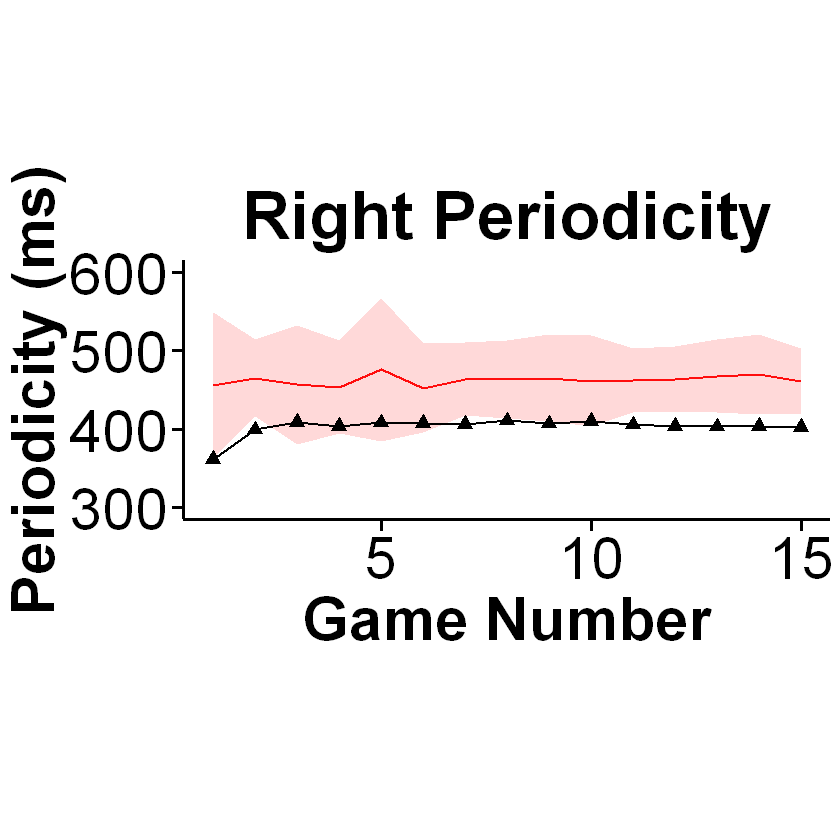

In [23]:
#Right periodicity
Shaded <- fast_data %>% filter(Agent=="Human_FFF") %>% filter(!RightPer=='NaN')
datac_fast <- summarySE(Shaded, measurevar="RightPer", groupvars=c("GameNb","Agent"))
ACTR <- fast_data %>% filter(Agent=='MS17_FFF') %>% filter(!RightPer=='NaN')
datac_model <- summarySE(ACTR, measurevar="RightPer", groupvars=c("GameNb","Agent"))

p4b <- ggplot(datac_fast) +  geom_line(aes(x=GameNb, y=RightPer,colour=Agent),size=sz_line) + geom_ribbon(aes(x=GameNb, ymin=RightPer-sd, ymax=RightPer+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Right Periodicity") +
      theme(plot.title = element_text(size=40,hjust=just_ratio,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', linewidth = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36 ,face ="bold"),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("brown1"), .2), name = "Variation (SD)") + 
     scale_color_manual(values = c("black","red"), name = "Agent means",labels=c("Human","Baseline model")) + 
     scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Periodicity (ms)", limits=c(300,600))
p4b <- p4b+ geom_line(data = datac_model, aes(x=GameNb, y=RightPer,color="Baseline model"),size=sz_line) +
      geom_point(data = datac_model, color = "black", aes(x=GameNb, y=RightPer), shape=17,size = 3.2)
p4b

pathFig <- './Figures_B/Right_Periodicity.png'
ggsave(pathFig,p4b,width=15,height=5)

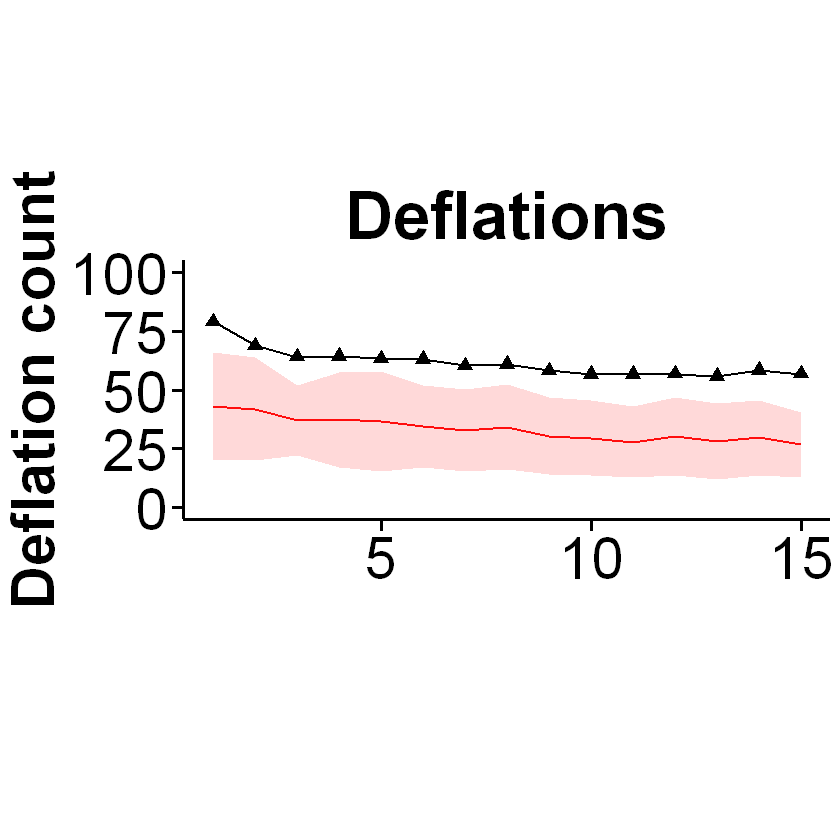

In [24]:
#Deflations
Shaded <- fast_data %>% filter(Agent=="Human_FFF")
datac_fast <- summarySE(Shaded, measurevar="Deflations", groupvars=c("GameNb","Agent"))
ACTR <- fast_data %>% filter(Agent=='MS17_FFF')
datac_model <- summarySE(ACTR, measurevar="Deflations", groupvars=c("GameNb","Agent"))

p5 <- ggplot(datac_fast) +  geom_line(aes(x=GameNb, y=Deflations,colour=Agent),size=sz_line) + geom_ribbon(aes(x=GameNb, ymin=Deflations-sd, ymax=Deflations+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Deflations") +
      theme(plot.title = element_text(size=40,hjust=just_ratio,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', linewidth = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36 ,face ="bold"),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("brown1"), .2), name = "Variation (SD)") + 
     scale_color_manual(values = c("black","red"), name = "Agent means",labels=c("Human","Baseline model")) + 
     scale_x_continuous(name="", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Deflation count", limits=c(0,100))
p5 <- p5+ geom_line(data = datac_model, aes(x=GameNb, y=Deflations,color="Baseline model"),size=sz_line) +
      geom_point(data = datac_model, color = "black", aes(x=GameNb, y=Deflations), shape=17,size = 3.2)
p5

pathFig <- './Figures_B/Deflations.png'
ggsave(pathFig,p5,width=15,height=5)

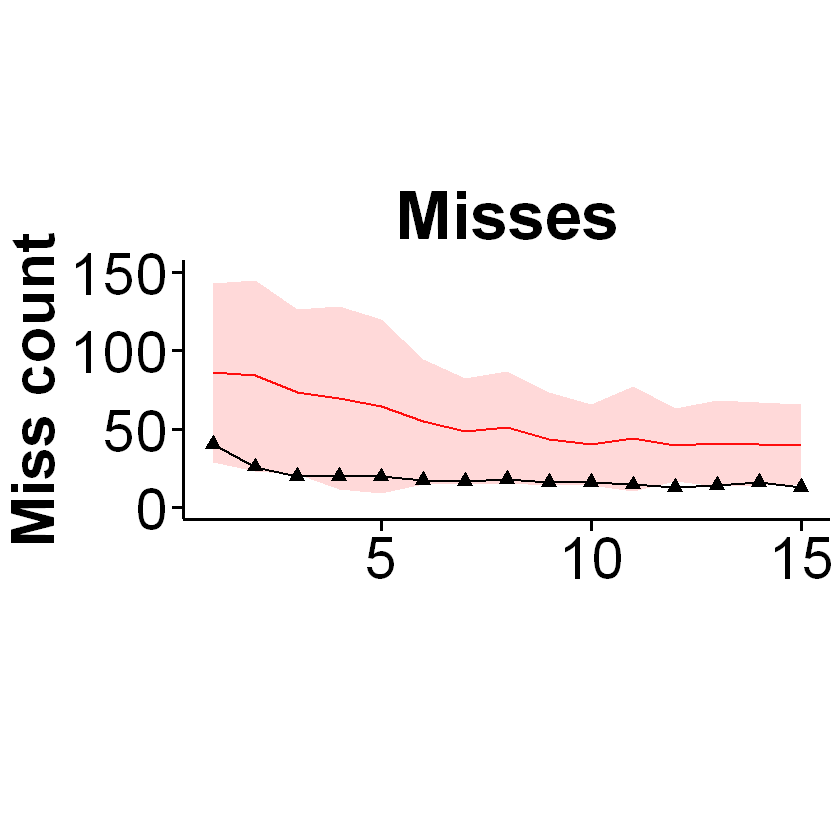

In [25]:
#Misses
Shaded <- fast_data %>% filter(Agent=="Human_FFF")
datac_fast <- summarySE(Shaded, measurevar="Misses", groupvars=c("GameNb","Agent"))
ACTR <- fast_data %>% filter(Agent=='MS17_FFF')
datac_model <- summarySE(ACTR, measurevar="Misses", groupvars=c("GameNb","Agent"))

p6 <- ggplot(datac_fast) +  geom_line(aes(x=GameNb, y=Misses,colour=Agent),size=sz_line) + geom_ribbon(aes(x=GameNb, ymin=Misses-sd, ymax=Misses+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Misses") +
      theme(plot.title = element_text(size=40,hjust=just_ratio,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', linewidth = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36 ,face ="bold"),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("brown1"), .2), name = "Variation (SD)") + 
     scale_color_manual(values = c("black","red"), name = "Agent means",labels=c("Human","Baseline model")) + 
     scale_x_continuous(name="", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Miss count", limits=c(0,150))
p6 <- p6+ geom_line(data = datac_model, aes(x=GameNb, y=Misses,color="Baseline model"),size=sz_line) +
      geom_point(data = datac_model, color = "black", aes(x=GameNb, y=Misses), shape=17,size = 3.2)
p6

pathFig <- './Figures_B/Misses.png'
ggsave(pathFig,p6,width=15,height=5)

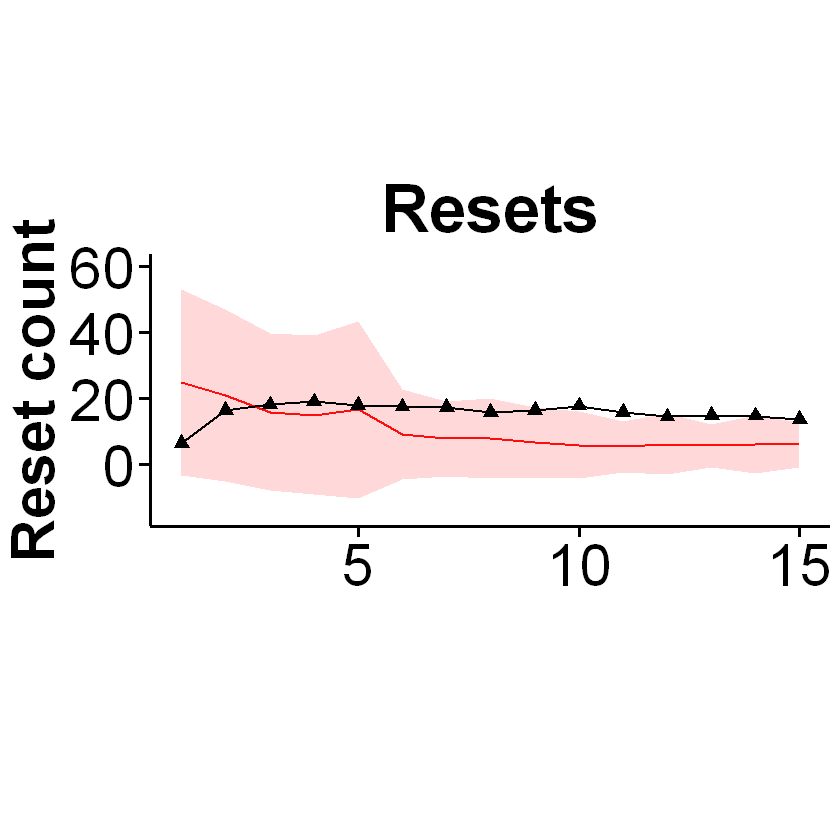

In [26]:
#Resets
Shaded <- fast_data %>% filter(Agent=="Human_FFF")
datac_fast <- summarySE(Shaded, measurevar="Resets", groupvars=c("GameNb","Agent"))
ACTR <- fast_data %>% filter(Agent=='MS17_FFF')
datac_model <- summarySE(ACTR, measurevar="Resets", groupvars=c("GameNb","Agent"))

p7 <- ggplot(datac_fast) +  geom_line(aes(x=GameNb, y=Resets,colour=Agent),size=sz_line) + geom_ribbon(aes(x=GameNb, ymin=Resets-sd, ymax=Resets+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Resets") +
      theme(plot.title = element_text(size=40,hjust=just_ratio,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', linewidth = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36 ,face ="bold"),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("brown1"), .2), name = "Variation (SD)") + 
     scale_color_manual(values = c("black","red"), name = "Agent means",labels=c("Human","Baseline model")) + 
     scale_x_continuous(name="", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Reset count", limits=c(-15,60))
p7 <- p7+ geom_line(data = datac_model, aes(x=GameNb, y=Resets,color="Baseline model"),size=sz_line) +
      geom_point(data = datac_model, color = "black", aes(x=GameNb, y=Resets), shape=17,size = 3.2)
p7

pathFig <- './Figures_B/Resets.png'
ggsave(pathFig,p7,width=15,height=5)

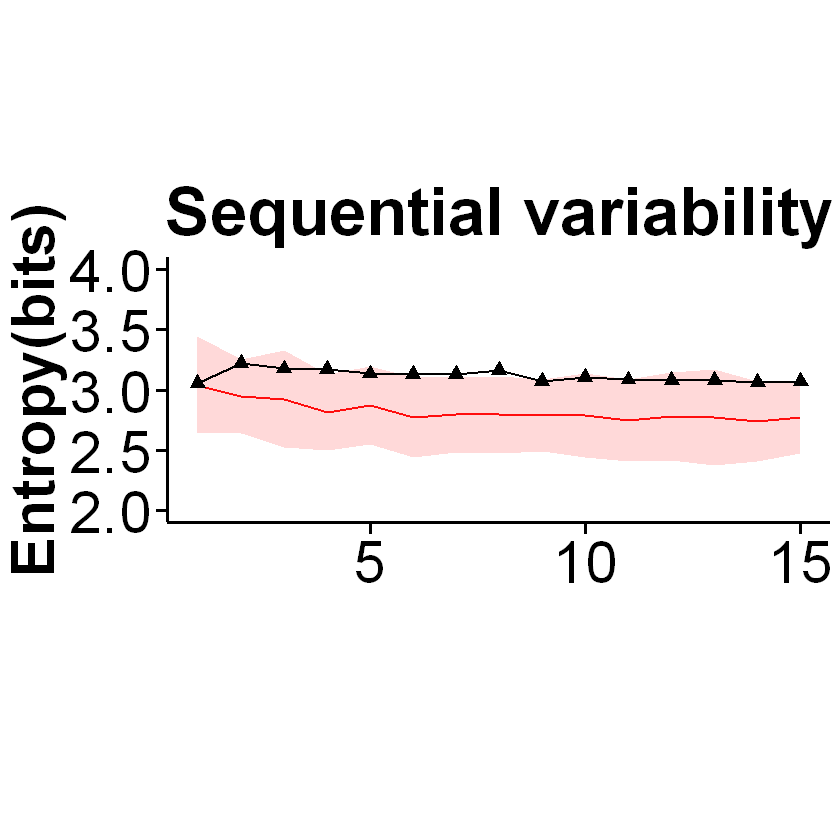

In [27]:
#Entropy
Shaded <- fast_data %>% filter(Agent=="Human_FFF") %>% filter(!Entropy=='NaN')
datac_fast <- summarySE(Shaded, measurevar="Entropy", groupvars=c("GameNb","Agent"))
ACTR <- fast_data %>% filter(Agent=='MS17_FFF') %>% filter(!Entropy=='NaN')
datac_model <- summarySE(ACTR, measurevar="Entropy", groupvars=c("GameNb","Agent"))

p8 <- ggplot(datac_fast) +  geom_line(aes(x=GameNb, y=Entropy,colour=Agent),size=sz_line) + geom_ribbon(aes(x=GameNb, ymin=Entropy-sd, ymax=Entropy+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Sequential variability") +
      theme(plot.title = element_text(size=40,hjust=just_ratio,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', linewidth = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36 ,face ="bold"),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("brown1"), .2), name = "Variation (SD)") + 
     scale_color_manual(values = c("black","red"), name = "Agent means",labels=c("Human","Baseline model")) + 
     scale_x_continuous(name="", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Entropy(bits)", limits=c(2,4))
p8 <- p8+ geom_line(data = datac_model, aes(x=GameNb, y=Entropy,color="Baseline model"),size=sz_line) +
      geom_point(data = datac_model, color = "black", aes(x=GameNb, y=Entropy), shape=17,size = 3.2)
p8

pathFig <- './Figures_B/Entropy.png'
ggsave(pathFig,p8,width=15,height=5)

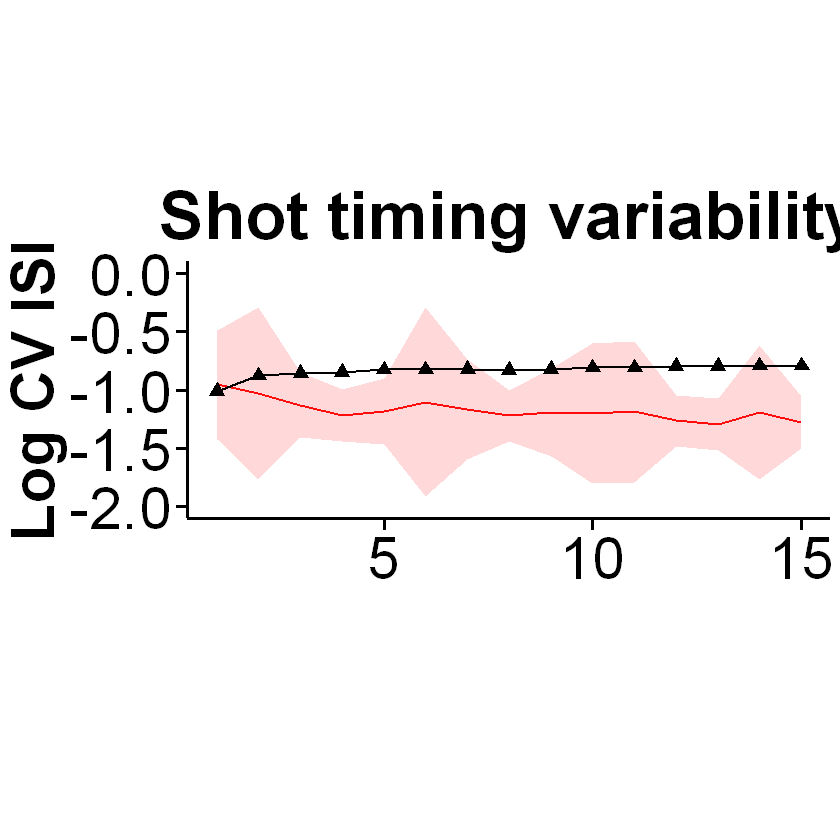

In [28]:
#Log CV ISI
Shaded <- fast_data %>% filter(Agent=="Human_FFF") %>% filter(!LogCV=='NaN')
datac_fast <- summarySE(Shaded, measurevar="LogCV", groupvars=c("GameNb","Agent"))
ACTR <- fast_data %>% filter(Agent=='MS17_FFF') %>% filter(!LogCV=='NaN')
datac_model <- summarySE(ACTR, measurevar="LogCV", groupvars=c("GameNb","Agent"))

p9 <- ggplot(datac_fast) +  geom_line(aes(x=GameNb, y=LogCV,colour=Agent),size=sz_line) + geom_ribbon(aes(x=GameNb, ymin=LogCV-sd, ymax=LogCV+sd, fill="Human")) +
     theme_classic() +
      ggtitle("Shot timing variability") +
      theme(plot.title = element_text(size=40,hjust=just_ratio,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', linewidth = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36 ,face ="bold"),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) +
     guides(color = guide_legend(override.aes = list(size=2))) +
     scale_fill_manual(values = alpha(c("brown1"), .2), name = "Variation (SD)") + 
     scale_color_manual(values = c("black","red"), name = "Agent means",labels=c("Human","Baseline model")) + 
     scale_x_continuous(name="", breaks=seq(0,15,5)) +
     scale_y_continuous(name="Log CV ISI", limits=c(-2,0))
p9 <- p9+ geom_line(data = datac_model, aes(x=GameNb, y=LogCV,color="Baseline model"),size=sz_line) +
      geom_point(data = datac_model, color = "black", aes(x=GameNb, y=LogCV), shape=17,size = 3.2)
p9

pathFig <- './Figures_B/LogCV.png'
ggsave(pathFig,p9,width=15,height=5)

In [31]:
# simple grid
gg3 <- plot_grid(p2,p8,p9,p7,p5,p6,p4,p3,p1,nrow=3)
ggsave("./Figures_B/All_graph_lines_comparison_plots.png",gg3,width=25,height=13)